# Loading libraries

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from kalman import Kalman_Filter
from AR1 import particle_filter, generator_ar_1, initial_particle, likelihood_function, transition_sample

# Generate Samples

In [47]:
def generator_ar(sigma_epsilon_square=2, sigma_eta_square=0.02, phi=0.975, mu=0.5, T=5000, seed=2345):
    np.random.seed(seed=seed)
    x = np.random.randn(1)
    ys = np.zeros(T)
    for i in range(T):
        ys[i] = x + np.random.randn(1) * np.sqrt(sigma_epsilon_square)
        x = (x - mu) * phi + mu + np.random.randn(1) * \
            np.sqrt(sigma_eta_square)
    print('sample generated with success !')
    return ys

In [48]:
# parameters
sigma_epsilon_square_0 = 2
sigma_eta_square_0 = 0.02
phi_0 = 0.975
mu_0 = 0.5

# T = 5000
# N = 3500
T = 5000
N = 300
observations_5000 = generator_ar(sigma_epsilon_square=sigma_epsilon_square_0,
                              sigma_eta_square=sigma_eta_square_0, phi=phi_0, mu=mu_0, T=T)

sample generated with success !


# Log-Error: kalman vs particle

In [25]:
A, b = phi_0, (1-phi_0)*mu_0
_, ct = Kalman_Filter.compute_log_likelihood(Y=observations_5000, 
                                             mu0=0, 
                                             V0=1, 
                                             A=A, 
                                             b=b, 
                                             V=sigma_eta_square_0, 
                                             V_epi=sigma_epsilon_square_0)

log_lkh_kalman = np.log(ct)
print('End kalman filter!')
print('Begin Particle Filter:')
initial_particles = initial_particle(N=N)
likelihoods_particle = particle_filter(observations=observations_5000, 
                              initial_particles=initial_particles,
                              likelihood_func=likelihood_function, 
                              transition=transition_sample, 
                              mu=mu_0,
                              phi=phi_0,
                              sigma_eta_square=sigma_eta_square_0,
                              sigma_epsilon_square=sigma_epsilon_square_0,
                              N=N,seed=1234)
log_lkh_particle = np.log(likelihoods_particle)
print('End Particle Filter!')

Begin compute likelihoods by kalman_filter
End kalman filter!
Begin Particle Filter:
End Particle Filter!


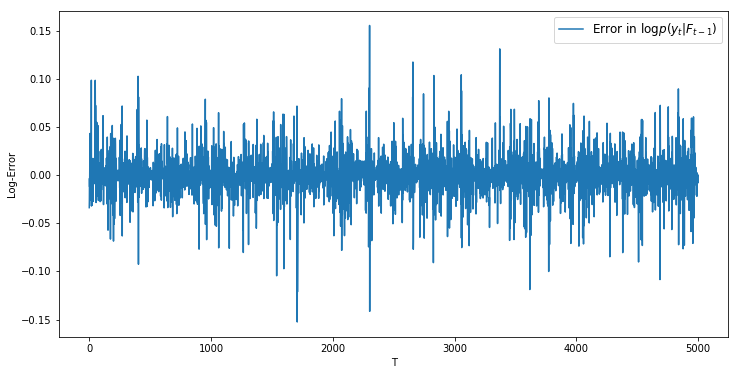

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(log_lkh_particle - log_lkh_kalman, label='Error in '+r'$\log p(y_{t}|F_{t-1})$')
#plt.plot(log_lkh_kalman, label='kalman')
#plt.plot(log_lkh_particle, label='particle')
plt.xlabel('T')
plt.ylabel('Log-Error')
plt.legend(fontsize=12)
plt.savefig('image/ar_logerror_300_1500.png')
plt.show()

In [43]:
# From guo's comptuer
mus = [i*0.03 for i in range(10,22)]
log_likelihoods = [[], []]
for mu in mus:
    A = phi_0
    b = (1 - phi_0) * mu
    log_lkh_1, _ = Kalman_Filter.compute_log_likelihood(Y=observations_5000,
                                    mu0=0, 
                                    V0=1, 
                                    A=A, 
                                    b=b, 
                                    V=sigma_eta_square_0,
                                    V_epi=sigma_epsilon_square_0)
    print("kalman: mu= %0.2f" % mu, " log-lokelihood= %0.3f" % log_lkh_1)
    log_likelihoods[0].append(log_lkh_1)
    
    initial_particles = initial_particle(N=N)
    likelihoods_particle = particle_filter(observations=observations_5000, 
                                  initial_particles=initial_particles,
                                  likelihood_func=likelihood_function, 
                                  transition=transition_sample, 
                                  mu=mu,
                                  phi=phi_0,
                                  sigma_eta_square=sigma_eta_square_0,
                                  sigma_epsilon_square=sigma_epsilon_square_0,
                                  N=N,seed=1234)
    log_lkh_2 = np.sum(np.log(likelihoods_particle))
    print("particle: mu= %0.2f" % mu, " log-lokelihood= %0.3f" % log_lkh_2)
    log_likelihoods[1].append(log_lkh_2)

Begin compute likelihoods by kalman_filter
kalman: mu= 0.30  log-lokelihood= -9033.691
particle: mu= 0.30  log-lokelihood= -9033.456
Begin compute likelihoods by kalman_filter
kalman: mu= 0.33  log-lokelihood= -9032.818
particle: mu= 0.33  log-lokelihood= -9032.516
Begin compute likelihoods by kalman_filter
kalman: mu= 0.36  log-lokelihood= -9032.076
particle: mu= 0.36  log-lokelihood= -9031.707
Begin compute likelihoods by kalman_filter
kalman: mu= 0.39  log-lokelihood= -9031.467
particle: mu= 0.39  log-lokelihood= -9031.032
Begin compute likelihoods by kalman_filter
kalman: mu= 0.42  log-lokelihood= -9030.990
particle: mu= 0.42  log-lokelihood= -9030.489
Begin compute likelihoods by kalman_filter
kalman: mu= 0.45  log-lokelihood= -9030.644
particle: mu= 0.45  log-lokelihood= -9030.079
Begin compute likelihoods by kalman_filter
kalman: mu= 0.48  log-lokelihood= -9030.430
particle: mu= 0.48  log-lokelihood= -9029.800
Begin compute likelihoods by kalman_filter
kalman: mu= 0.51  log-loke

KeyboardInterrupt: 

In [51]:
etas = [i*0.01 for i in range(12,20)]
log_likelihoods_eta = [[], []]
for eta in etas:
    A = phi_0
    b = (1 - phi_0) * mu_0
    log_lkh_1, _ = Kalman_Filter.compute_log_likelihood(Y=observations_5000,
                                    mu0=0, 
                                    V0=1, 
                                    A=A, 
                                    b=b, 
                                    V=eta**2,
                                    V_epi=sigma_epsilon_square_0)
    print("kalman: sigma_eta= %0.2f" % eta, " log-lokelihood= %0.3f" % log_lkh_1)
    log_likelihoods_eta[0].append(log_lkh_1)
    
    initial_particles = initial_particle(N=N)
    likelihoods_particle = particle_filter(observations=observations_5000, 
                                  initial_particles=initial_particles,
                                  likelihood_func=likelihood_function, 
                                  transition=transition_sample, 
                                  mu=mu_0,
                                  phi=phi_0,
                                  sigma_eta_square=eta**2,
                                  sigma_epsilon_square=sigma_epsilon_square_0,
                                  N=N,seed=1234)
    log_lkh_2 = np.sum(np.log(likelihoods_particle))
    print("particle: sigma_eta= %0.2f" % eta, " log-lokelihood= %0.3f" % log_lkh_2)
    log_likelihoods_eta[1].append(log_lkh_2)

Begin compute likelihoods by kalman_filter
kalman: sigma_eta= 0.17  log-lokelihood= -8941.782
particle: sigma_eta= 0.17  log-lokelihood= -8944.779
Begin compute likelihoods by kalman_filter
kalman: sigma_eta= 0.18  log-lokelihood= -8944.064
particle: sigma_eta= 0.18  log-lokelihood= -8947.116
Begin compute likelihoods by kalman_filter
kalman: sigma_eta= 0.19  log-lokelihood= -8947.105
particle: sigma_eta= 0.19  log-lokelihood= -8950.200


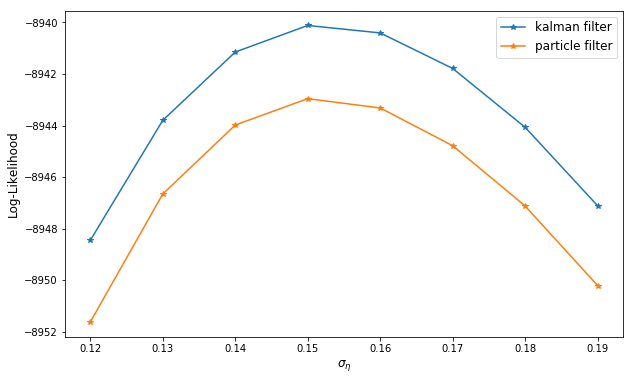

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(etas, log_likelihoods_eta[0], '-*',label='kalman filter')
plt.plot(etas, log_likelihoods_eta[1], '*-',label='particle filter')
plt.xlabel(r'$\sigma_{\eta}$', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('image/eta_log_likelihood_300_5000.png')
plt.show()

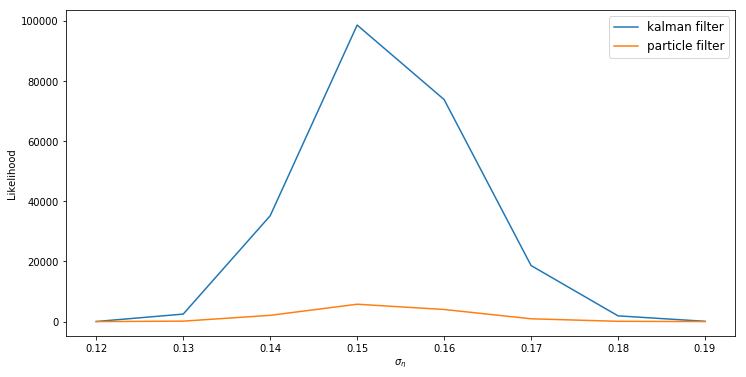

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(etas, np.exp(log_likelihoods_eta[0]-log_likelihoods_eta[1][0]), label='kalman filter')
plt.plot(etas, np.exp(log_likelihoods_eta[1]-log_likelihoods_eta[1][0]), label='particle filter')
plt.xlabel(r'$\sigma_{\eta}$')
plt.ylabel('Likelihood')
plt.legend(fontsize=12)
plt.show()